In [1]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_dataset = pd.read_csv('/content/credit_risk.csv')
raw_dataset.head()

,checking_account_status,duration,credit_history,purpose,amount,savings_account_status,employment_years,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,number_of_credits,job,people_liable,telephone,foreign_worker,full_repaid
0,below_0,6,critical_account,radio_TV,1169,unknown,above_7,4,M_single,NaN,...,real_estate,67,NaN,own,2,official,1,1,1,1
1,0_to_200,48,existing_credit_paid,radio_TV,5951,below_100,between_1_4,2,F_not_single,NaN,...,real_estate,22,NaN,own,1,official,1,0,1,0
2,no_account,12,critical_account,education,2096,below_100,between_4_7,2,M_single,NaN,...,real_estate,49,NaN,own,1,unskilled,2,0,1,1
3,below_0,42,existing_credit_paid,furniture_equipment,7882,below_100,between_4_7,2,M_single,guarantor,...,life_insurance,45,NaN,free,1,official,2,0,1,1
4,below_0,24,delay_in_paying,car_new,4870,below_100,between_1_4,3,M_single,NaN,...,no_property,53,NaN,free,2,official,2,0,1,0


In [4]:
# From category to numerical
category_columns = [
    'checking_account_status', 'credit_history', 'purpose',
    'savings_account_status', 'employment_years', 'personal_status',
    'other_debtors', 'property', 'other_installment_plans', 'housing', 'job']
dataset = pd.get_dummies(raw_dataset, columns=category_columns, drop_first=True)

# Creating the time and event columns
time_column = 'duration'
event_column = 'full_repaid'

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

In [5]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates
The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


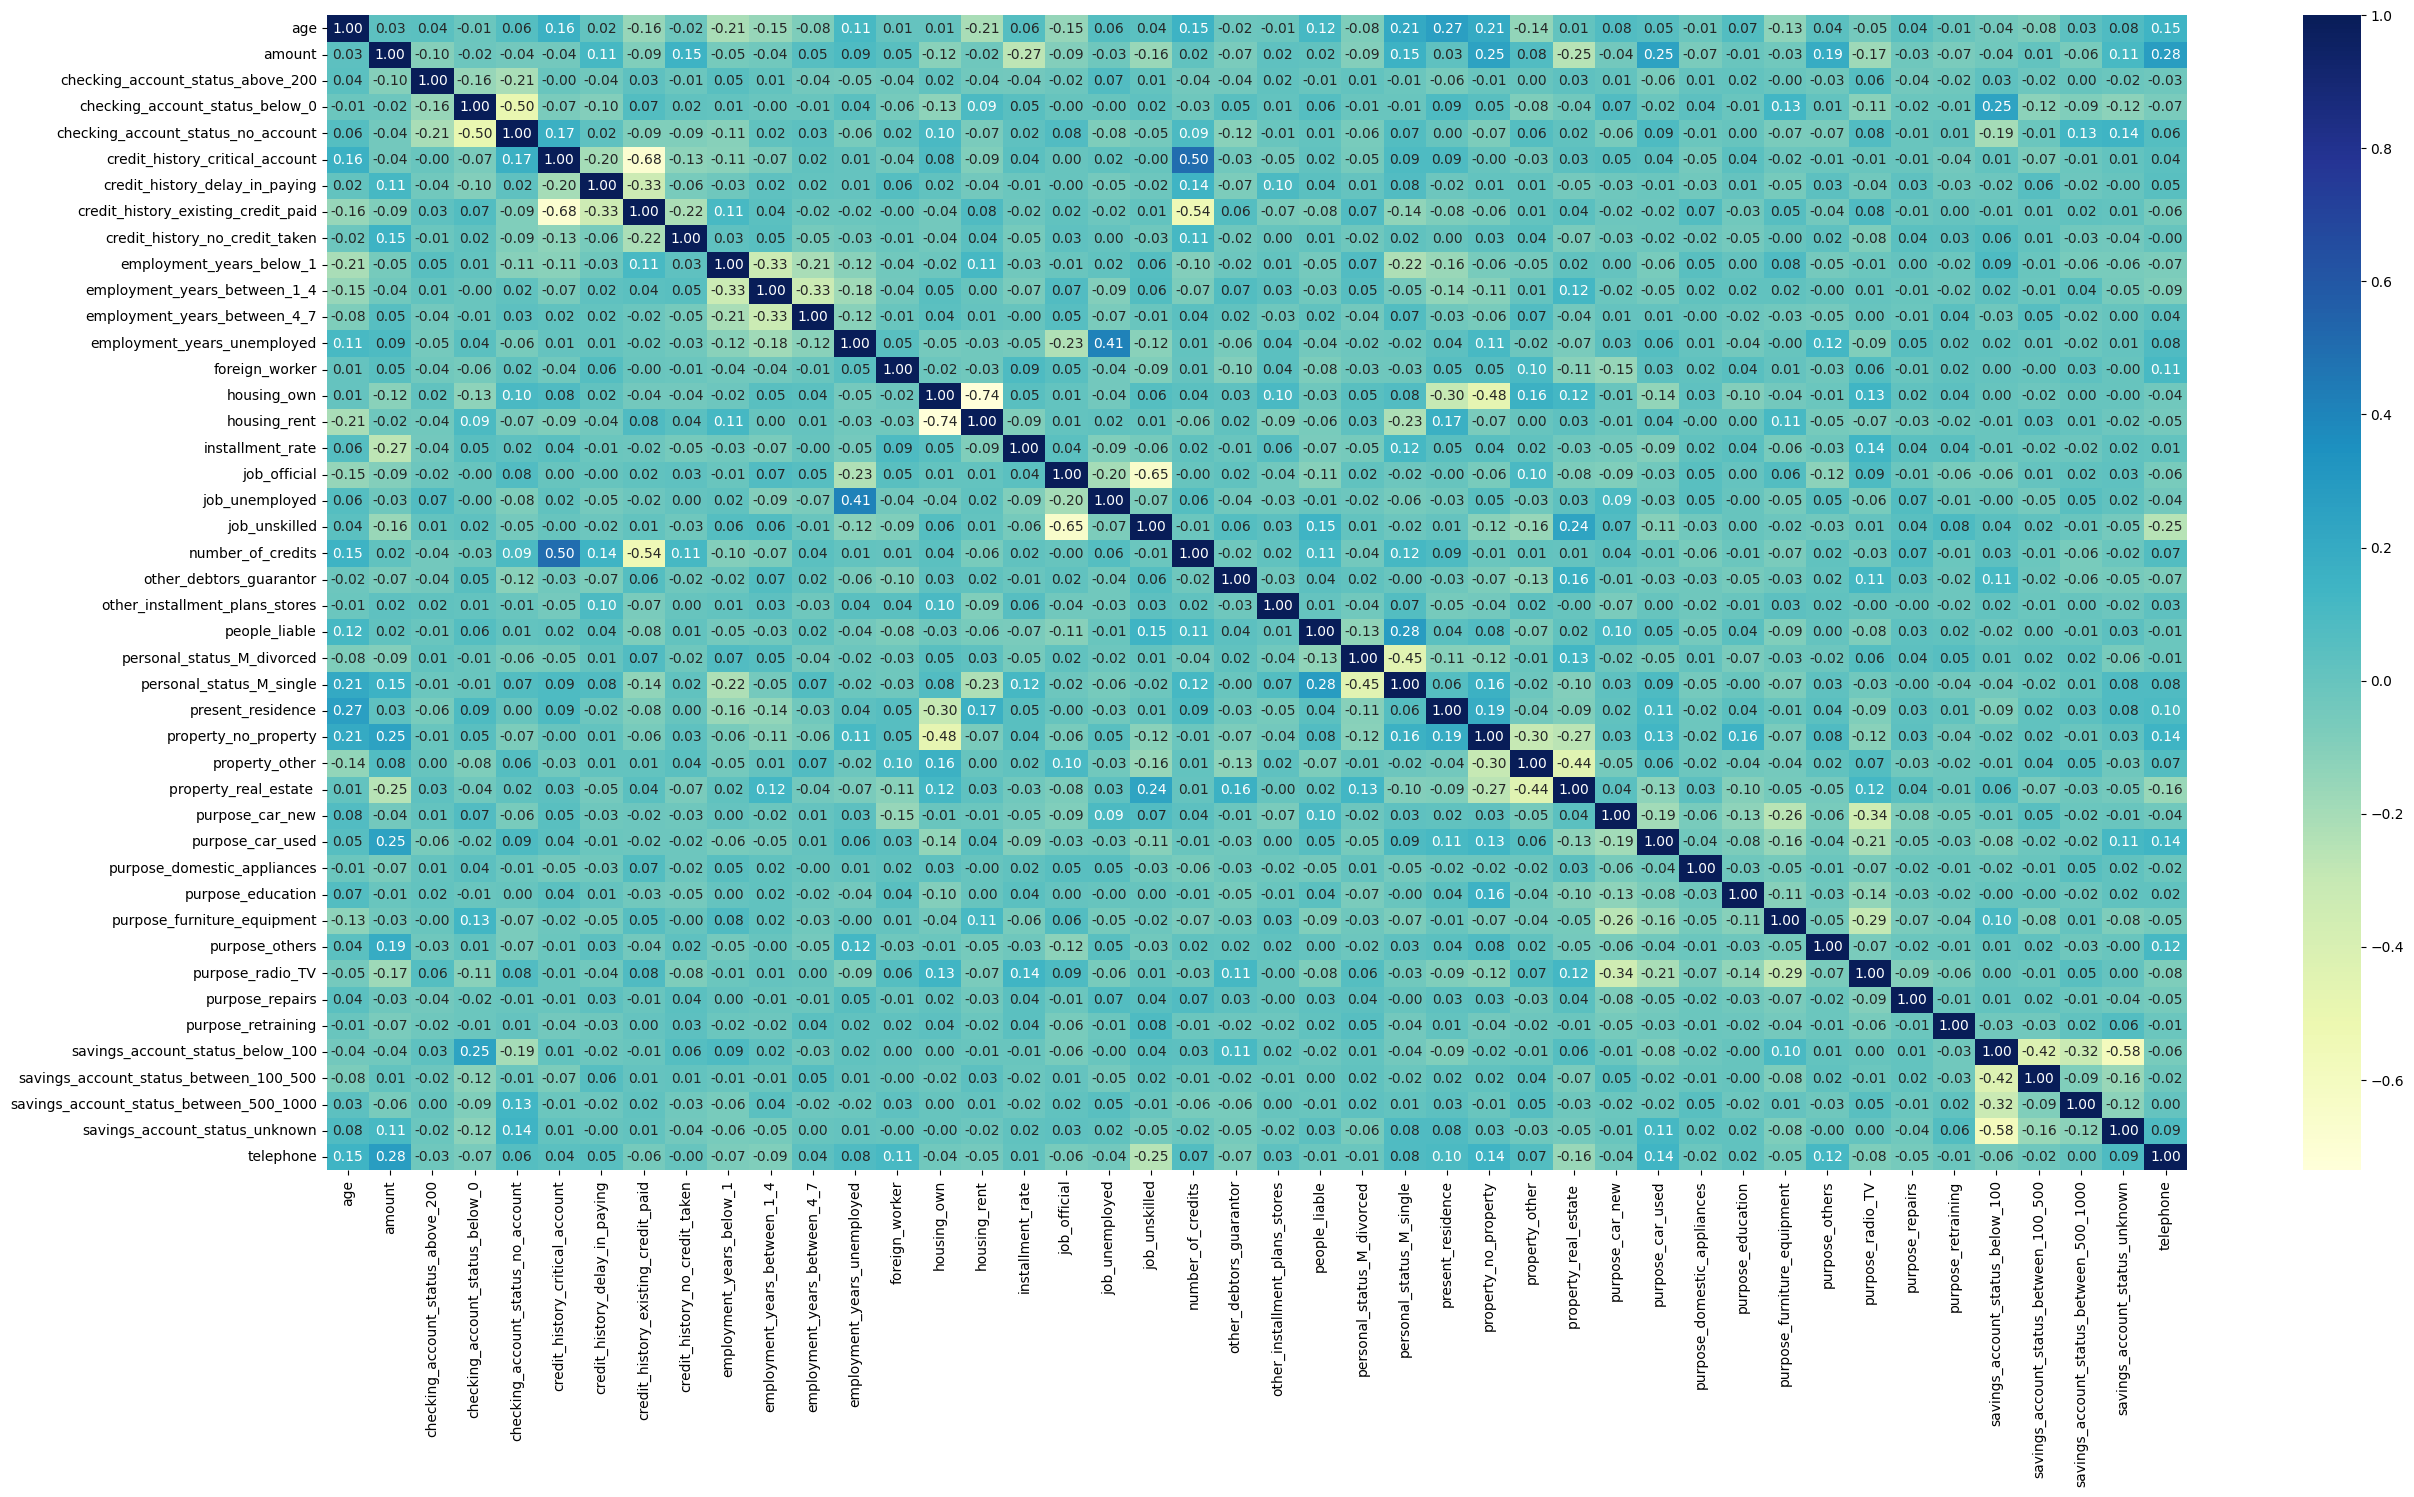

In [6]:
# prompt: create a correlation matrix with these properties;
# correlation_matrix(dataset[features], figure_size=(30,15), text_fontsize=10)

def correlation_matrix(df, figure_size=(10,8), text_fontsize=12):
  '''
  Plots correlation matrix
  args:
    df: pandas dataframe
    figure_size: tuple, matplotlib figure size
    text_fontsize: int, fontsize for correlation values
  '''
  corr_matrix = df.corr()
  fig, ax = plt.subplots(figsize=figure_size)
  sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax, cmap="YlGnBu",
              annot_kws={"fontsize":text_fontsize})
  plt.show()
correlation_matrix(dataset[features], figure_size=(30,15), text_fontsize=10)


In [7]:
to_remove = ['credit_history_existing_credit_paid', 'housing_own']
features = np.setdiff1d(features, to_remove).tolist()

In [8]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.4)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True, dropout_rate=0.5, l2_lambda=0.01):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda))(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.reduce_prod(tf.pow(tf.linalg.matmul(y_pred, Triangle), y_true), axis=1)

        reduc_phi_uncens = tf.reduce_sum(phi_uncens, axis=1)

        z_uncens = tf.reduce_prod(tf.pow(tf.linalg.matmul(y_pred, Triangle), 1. - y_true), axis=1)
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss
    def loss_function(self, y_true, y_pred):
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        # Calculate phi_uncens without reducing dimensions
        phi_uncens = tf.pow(tf.linalg.matmul(y_pred, Triangle), y_true)

        # Sum over all elements of phi_uncens
        loss_uncens = -tf.reduce_sum(tf.math.log(phi_uncens))

        # Similarly for z_uncens, calculate without reducing dimensions
        z_uncens = tf.pow(tf.linalg.matmul(y_pred, Triangle), 1. - y_true)
        loss_cens = tf.reduce_sum(tf.math.log(z_uncens))

        loss = loss_uncens + loss_cens
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1)
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X, T, E):
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        _, _, Survival = self.predict(X)

        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E, T, -Survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(Survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        self.plot_actual_vs_predicted(T, E, Survival)

        return c_index, integrated_brier_score

    def plot_brier_score(self, time_grid, brier_scores, integrated_brier_score):
        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, brier_scores, label=f'IBS: {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actual_vs_predicted(self, T, E, Survival):
        time_grid = np.linspace(0, T.max(), 100)
        actual_events = np.array([(T >= t).sum() for t in time_grid])
        predicted_events = np.array([(Survival[:, :-1] >= t).sum() for t in time_grid])

        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, actual_events, label='Actual', color='red')
        plt.plot(time_grid, predicted_events, label='Predicted', color='blue')
        plt.fill_between(time_grid, predicted_events - 1.96 * np.sqrt(predicted_events),
                         predicted_events + 1.96 * np.sqrt(predicted_events), color='blue', alpha=0.2,
                         label='Confidence Intervals')
        plt.title('Actual vs Predicted Number of Events Over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Events')
        plt.legend()
        plt.grid(True)
        plt.show()




In [ ]:

# Initializing the Neural MTLR with a time axis split into 100 intervals
structure = [
                {'activation': 'relu', 'num_units': 70},
                {'activation': 'swish', 'num_units': 70},
            ]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fitting the model
model.fit(X_train, T_train, E_train, epochs=500, batch_size=32, verbose=True, validation_split=0.2)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5936.6577 - val_loss: 4857.5728
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5634.6299 - val_loss: 4856.1748
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5659.3857 - val_loss: 4854.7510
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5677.5688 - val_loss: 4853.3652
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5491.9902 - val_loss: 4851.9873
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5823.8262 - val_loss: 4850.5801
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6009.4678 - val_loss: 4849.1631
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6165.2407 - val_loss: 4847.7720
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5870.4995 - val_loss: 4846.3701
Epoch 10/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5976.4604 - val_loss: 4844.9561
Epoch 11/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6117.6157 - val_loss: 4843.5

In [ ]:
# Data preparation code remains the same
# Example usage
structure = [{'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fit the model
model.fit(X_train, T_train, E_train, epochs=1000, batch_size=32, verbose=True, validation_split=0.2)




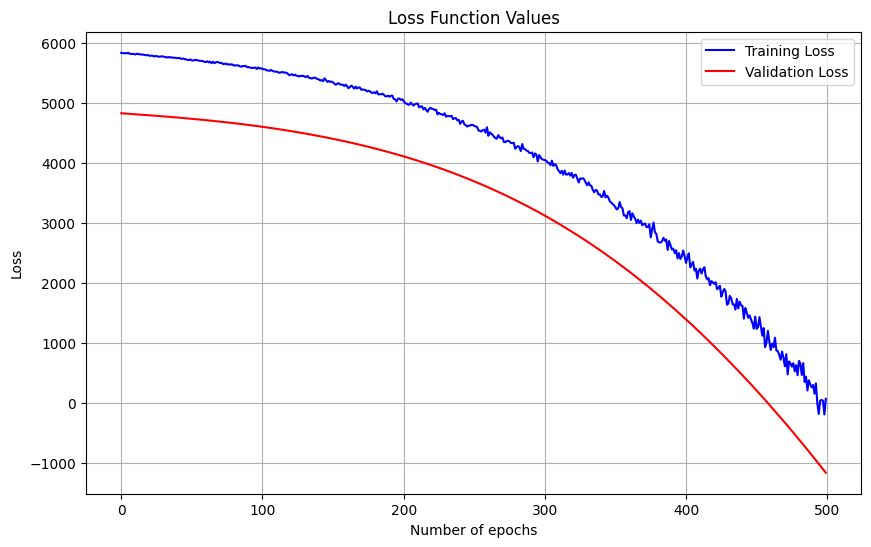

In [16]:
# Plot the loss curve
model.plot_loss_curve()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


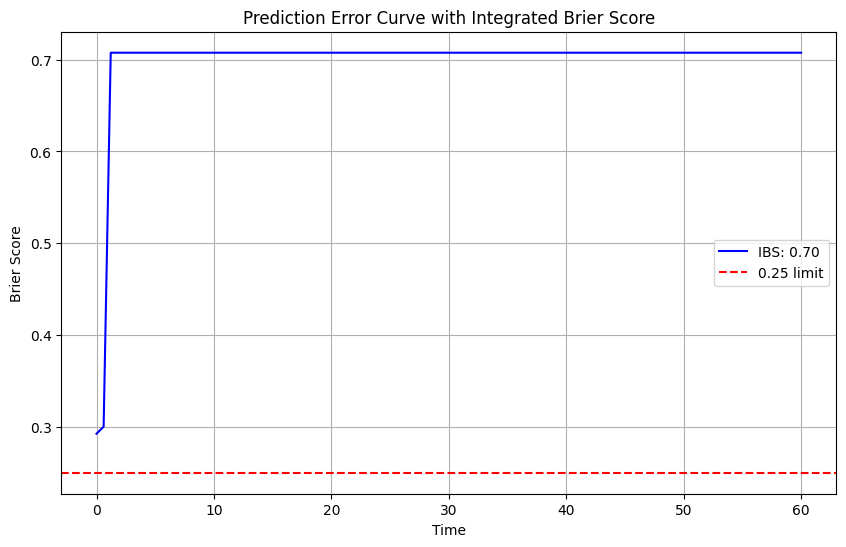

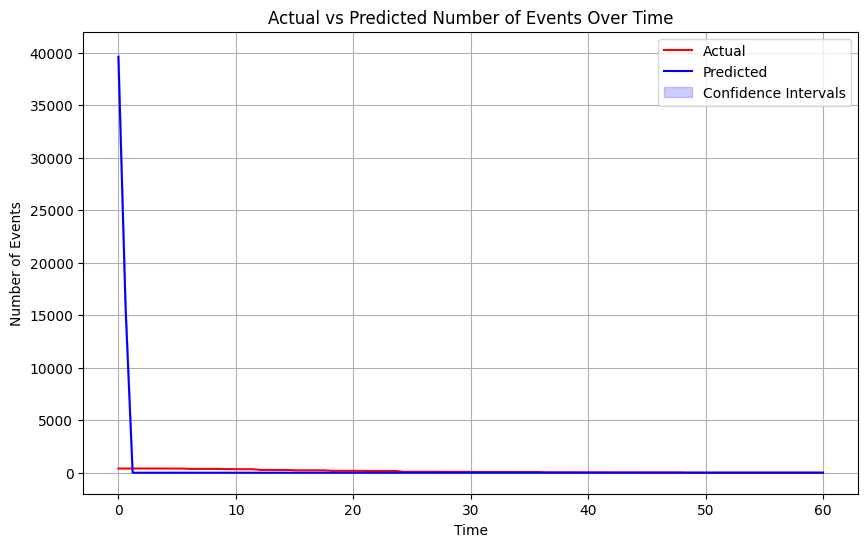

c-index: 0.46959754655884317, Brier score: 0.701289424703107


In [17]:
# Evaluate the model
c_index, brier_score = model.evaluate(X_test, T_test, E_test == 1) # Access the 'SURVIVAL' column and create a boolean array
print(f"c-index: {c_index}, Brier score: {brier_score}")

In [ ]:
# Make predictions (example)
hazard, density, Survival = model.predict(X_test.values[:5])
print(hazard)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.0103805  0.0104881  0.01058899 0.01069786 0.0108116  0.0109274
  0.01104701 0.01116882 0.0112909  0.01141342 0.01154173 0.01167348
  0.01180685 0.01194669 0.01208774 0.0122336  0.01238204 0.01253613
  0.01268848 0.01284878 0.01301347 0.01317648 0.01335083 0.01352231
  0.01370178 0.01388857 0.01407891 0.01427486 0.01447601 0.0146826
  0.01489782 0.01511732 0.01532894 0.01556629 0.0158095  0.0160613
  0.01631837 0.01658728 0.01685435 0.01713869 0.01743472 0.01773641
  0.01804858 0.0183723  0.01870557 0.01904302 0.01938311 0.0197528
  0.02013917 0.02054669 0.02097054 0.02140915 0.02187424 0.02235853
  0.02286505 0.02336452 0.02391734 0.0244973  0.02510194 0.02572975
  0.0263954  0.02710417 0.02785112 0.02860878 0.02942938 0.03031183
  0.03124164 0.03223328 0.0332782  0.0343781  0.03558798 0.03687759
  0.03827515 0.0397464  0.04136375 0.04309536 0.04501546 0.04704567
  0.04925213 0.05175458 0.05442638 0.05739825 0.06081771 0.06462426
  0.06898071 0